## PyTorch

In [1]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import torchvision.transforms as transforms

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

c:\ProgramData\Miniconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\ProgramData\Miniconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### MNIST

In [4]:
train_dataset = datasets.MNIST(root='private', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='private', 
                              train=False, 
                              transform=transforms.ToTensor())

In [5]:
# 超参数
batch_size = 256
num_epochs = 25
learning_rate = 0.1
random_seed = 123

num_features = 784
num_classes = 10

In [6]:
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape) #NCHW
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])


In [7]:
class SoftmaxRegression(torch.nn.Module):

    def __init__(self, num_features, num_classes):
        super(SoftmaxRegression, self).__init__()
        self.linear = torch.nn.Linear(num_features, num_classes)
        
        self.linear.weight.detach().zero_()
        self.linear.bias.detach().zero_()
        
    def forward(self, x):
        logits = self.linear(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

model = SoftmaxRegression(num_features=num_features,
                          num_classes=num_classes)
model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

In [8]:
# 便于复现
torch.manual_seed(random_seed)

def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    
    for features, targets in data_loader:
        features = features.view(-1, 28*28).to(device)
        targets = targets.to(device)
        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
        
    return correct_pred.float() / num_examples * 100

start_time = time.time()
epoch_costs = []
for epoch in range(num_epochs):
    avg_cost = 0.
    for batch_idx, (features, targets) in enumerate(train_loader):
        features = features.view(-1, 28*28).to(device)
        targets = targets.to(device)
        
        logits, probas = model(features)
        
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        cost.backward()
        avg_cost += cost
        
        optimizer.step()
        
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_dataset)//batch_size, cost))
            
    with torch.set_grad_enabled(False):
        avg_cost = avg_cost/len(train_dataset)
        epoch_costs.append(avg_cost)
        print('Epoch: %03d/%03d training accuracy: %.2f%%' % (
              epoch+1, num_epochs, 
              compute_accuracy(model, train_loader)))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/025 | Batch 000/234 | Cost: 2.3026
Epoch: 001/025 | Batch 050/234 | Cost: 0.7693
Epoch: 001/025 | Batch 100/234 | Cost: 0.5321
Epoch: 001/025 | Batch 150/234 | Cost: 0.5617
Epoch: 001/025 | Batch 200/234 | Cost: 0.5501
Epoch: 001/025 training accuracy: 88.05%
Time elapsed: 0.21 min
Epoch: 002/025 | Batch 000/234 | Cost: 0.4793
Epoch: 002/025 | Batch 050/234 | Cost: 0.3686
Epoch: 002/025 | Batch 100/234 | Cost: 0.4535
Epoch: 002/025 | Batch 150/234 | Cost: 0.3731
Epoch: 002/025 | Batch 200/234 | Cost: 0.4791
Epoch: 002/025 training accuracy: 89.26%
Time elapsed: 0.38 min
Epoch: 003/025 | Batch 000/234 | Cost: 0.4057
Epoch: 003/025 | Batch 050/234 | Cost: 0.4456
Epoch: 003/025 | Batch 100/234 | Cost: 0.3770
Epoch: 003/025 | Batch 150/234 | Cost: 0.3893
Epoch: 003/025 | Batch 200/234 | Cost: 0.2996
Epoch: 003/025 training accuracy: 89.94%
Time elapsed: 0.55 min
Epoch: 004/025 | Batch 000/234 | Cost: 0.4298
Epoch: 004/025 | Batch 050/234 | Cost: 0.3918
Epoch: 004/025 | Batch 100

In [9]:
torch.save(model.state_dict(), 'private/softmax.ckpt')

In [11]:
model = SoftmaxRegression(num_features=num_features,
                            num_classes=num_classes)
model.load_state_dict(torch.load('private/softmax.ckpt'))
model.eval()
model.to(device)

SoftmaxRegression(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)

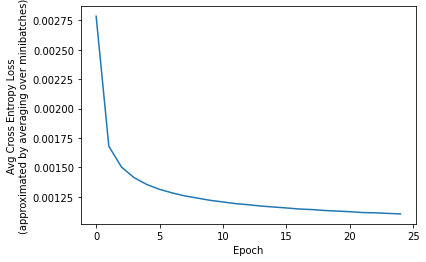

In [12]:
plt.plot([cost.detach().cpu() for cost in epoch_costs])
plt.ylabel('Avg Cross Entropy Loss\n(approximated by averaging over minibatches)')
plt.xlabel('Epoch')
plt.show()

In [13]:
print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 92.24%


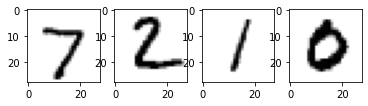

In [14]:
for features, targets in test_loader:
    break
    
fig, ax = plt.subplots(1, 4)
for i in range(4):
    ax[i].imshow(features[i].view(28, 28), cmap=matplotlib.cm.binary)

plt.show()

In [15]:
_, predictions = model.forward(features[:4].view(-1, 28*28).to(device))
predictions = torch.argmax(predictions, dim=1)
print('Predicted labels', predictions)

Predicted labels tensor([7, 2, 1, 0], device='cuda:0')


In [16]:
def compute_conf_matrix(model, data_loader):
    conf_matrix = np.zeros((10,10))
    for features, targets in data_loader:
        features = features.view(-1, 28*28).to(device)
        targets = targets.to(device)
        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        
        for t, p in zip(targets.view(-1), predicted_labels.view(-1)):
            conf_matrix[t.long(), p.long()] += 1

    return conf_matrix

conf_matrix = compute_conf_matrix(model, test_loader)
print(conf_matrix)

[[9.590e+02 0.000e+00 2.000e+00 2.000e+00 0.000e+00 4.000e+00 9.000e+00
  1.000e+00 3.000e+00 0.000e+00]
 [0.000e+00 1.108e+03 2.000e+00 2.000e+00 0.000e+00 2.000e+00 4.000e+00
  2.000e+00 1.500e+01 0.000e+00]
 [7.000e+00 7.000e+00 9.160e+02 1.700e+01 1.000e+01 2.000e+00 1.400e+01
  1.000e+01 3.900e+01 1.000e+01]
 [3.000e+00 1.000e+00 2.100e+01 9.200e+02 0.000e+00 2.400e+01 2.000e+00
  9.000e+00 1.900e+01 1.100e+01]
 [1.000e+00 2.000e+00 3.000e+00 1.000e+00 9.100e+02 0.000e+00 1.300e+01
  2.000e+00 8.000e+00 4.200e+01]
 [9.000e+00 3.000e+00 3.000e+00 3.600e+01 9.000e+00 7.650e+02 1.800e+01
  7.000e+00 3.500e+01 7.000e+00]
 [1.100e+01 3.000e+00 3.000e+00 2.000e+00 1.000e+01 1.100e+01 9.120e+02
  2.000e+00 4.000e+00 0.000e+00]
 [1.000e+00 8.000e+00 2.100e+01 9.000e+00 6.000e+00 1.000e+00 0.000e+00
  9.410e+02 3.000e+00 3.800e+01]
 [6.000e+00 6.000e+00 6.000e+00 1.900e+01 9.000e+00 2.200e+01 1.000e+01
  1.000e+01 8.780e+02 8.000e+00]
 [1.000e+01 6.000e+00 2.000e+00 1.100e+01 3.100e+01 6.0

Text(69.0, 0.5, 'True')

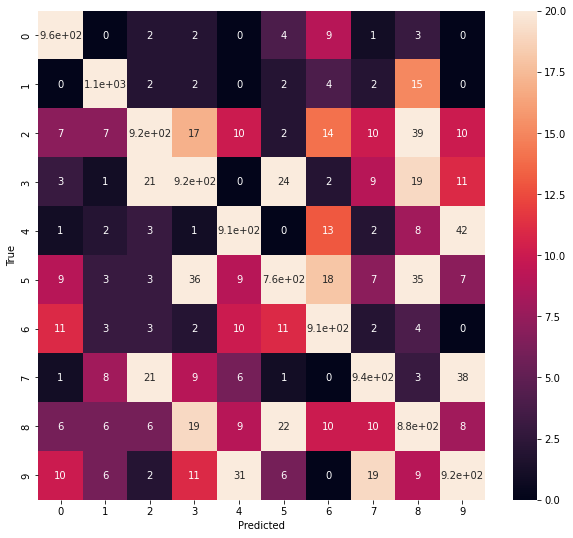

In [17]:
plt.subplots(figsize=(10,9))
ax = sns.heatmap(conf_matrix, annot=True, vmax=20)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')

## MindSpore

In [ ]:
from mindspore import Tensor
import mindspore.nn as nn
import mindspore.ops as ops

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from mindspore import context
context.set_context(mode=context.GRAPH_MODE, device_target="GPU")

### MNIST

In [10]:
from mindvision.dataset import Mnist

download_train = Mnist(path="private/mnist", split="train", batch_size=256, repeat_num=1, shuffle=True, resize=28, download=True)
download_eval = Mnist(path="private/mnist", split="test", batch_size=256, resize=28, download=True)

dataset_train = download_train.run()
dataset_eval = download_eval.run()

In [4]:
class SoftmaxRegression(nn.Cell):
    def __init__(self, num_features, num_classes):
        super(SoftmaxRegression, self).__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Dense(num_features, num_classes)
        self.softmax = ops.Softmax(axis=-1)
    
    def construct(self, x):
        x = self.flatten(x)
        logits = self.linear(x)
        probas = self.softmax(logits)
        return probas

network = SoftmaxRegression(784, 10)

In [5]:
# 定义损失函数
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')

# 定义优化器函数
net_opt = nn.SGD(network.trainable_params(), learning_rate=0.1)

In [6]:
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig

# 设置模型保存参数
config_ck = CheckpointConfig(save_checkpoint_steps=6000, keep_checkpoint_max=10)

# 应用模型保存参数
ckpoint = ModelCheckpoint(prefix="softmax", directory="private/softmax", config=config_ck)

In [11]:
from mindvision.engine.callback import LossMonitor
from mindspore.train import Model

# 初始化模型参数
model = Model(network, loss_fn=net_loss, optimizer=net_opt, metrics={'accuracy'})

# 训练网络模型
model.train(25, dataset_train, callbacks=[ckpoint, LossMonitor(0.1, 1875)])

Epoch time: 3071.370 ms, per step time: 13.126 ms, avg loss: 1.622
Epoch time: 1833.806 ms, per step time: 7.837 ms, avg loss: 1.592
Epoch time: 1837.327 ms, per step time: 7.852 ms, avg loss: 1.628
Epoch time: 1848.785 ms, per step time: 7.901 ms, avg loss: 1.593
Epoch time: 1790.716 ms, per step time: 7.653 ms, avg loss: 1.588
Epoch time: 1882.923 ms, per step time: 8.047 ms, avg loss: 1.564
Epoch time: 1820.461 ms, per step time: 7.780 ms, avg loss: 1.558
Epoch time: 1869.837 ms, per step time: 7.991 ms, avg loss: 1.550
Epoch:[  8/ 25], step:[  234/  234], loss:[1.587/1.587], time:1905.845 ms, lr:0.10000
Epoch time: 1908.851 ms, per step time: 8.157 ms, avg loss: 1.587
Epoch time: 1914.203 ms, per step time: 8.180 ms, avg loss: 1.550
Epoch time: 1847.644 ms, per step time: 7.896 ms, avg loss: 1.571
Epoch time: 1870.595 ms, per step time: 7.994 ms, avg loss: 1.551
Epoch time: 1811.671 ms, per step time: 7.742 ms, avg loss: 1.570
Epoch time: 1888.181 ms, per step time: 8.069 ms, avg l

In [12]:
acc = model.eval(dataset_eval)

print("{}".format(acc))

{'accuracy': 0.92578125}


In [8]:
from mindspore import load_checkpoint, load_param_into_net

# 加载已经保存的用于测试的模型
param_dict = load_checkpoint("private/softmax/softmax-1_1875.ckpt")
# 加载参数到网络中
load_param_into_net(network, param_dict)

[]

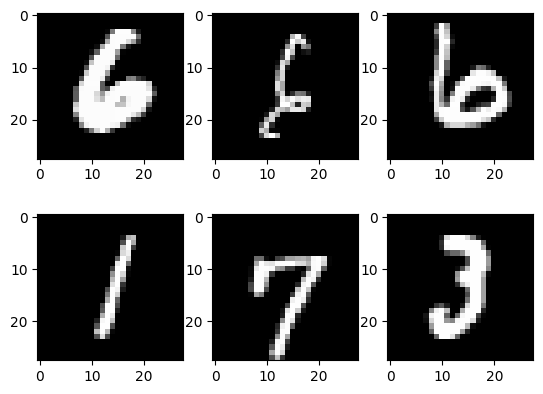

Predicted: "[6 2 6 1 7 3]", Actual: "[6 6 6 1 7 3]"


In [13]:
import numpy as np
from mindspore import Tensor
import matplotlib.pyplot as plt

mnist = Mnist("private/mnist", split="train", batch_size=6, resize=28)
dataset_infer = mnist.run()
ds_test = dataset_infer.create_dict_iterator()
data = next(ds_test)
images = data["image"].asnumpy()
labels = data["label"].asnumpy()

plt.figure()
for i in range(1, 7):
    plt.subplot(2, 3, i)
    plt.imshow(images[i-1][0], interpolation="None", cmap="gray")
plt.show()

# 使用函数model.predict预测image对应分类
output = model.predict(Tensor(data['image']))
predicted = np.argmax(output.asnumpy(), axis=1)

# 输出预测分类与实际分类
print(f'Predicted: "{predicted}", Actual: "{labels}"')

In [14]:
mnist = Mnist("private/mnist", split="train", batch_size=32, resize=28)
dataset_infer = mnist.run()
ds_test = dataset_infer.create_dict_iterator()

conf_matrix = np.zeros((10,10))

for data in ds_test:
    images = data["image"].asnumpy()
    labels = data["label"].asnumpy()
    
    output = model.predict(Tensor(data['image']))
    predicted = np.argmax(output.asnumpy(), axis=1)
    
    # update confusion matrix
    for t, p in zip(labels, predicted):
        conf_matrix[t, p] += 1

        
print(conf_matrix)

[[5.771e+03 1.000e+00 1.500e+01 1.000e+01 1.500e+01 2.200e+01 3.600e+01
  6.000e+00 4.300e+01 4.000e+00]
 [1.000e+00 6.539e+03 4.600e+01 2.700e+01 7.000e+00 3.000e+01 8.000e+00
  2.100e+01 5.600e+01 7.000e+00]
 [4.200e+01 3.600e+01 5.359e+03 7.800e+01 1.110e+02 2.000e+01 6.900e+01
  8.700e+01 1.340e+02 2.200e+01]
 [1.800e+01 1.800e+01 1.320e+02 5.499e+03 6.000e+00 1.880e+02 2.600e+01
  6.400e+01 1.190e+02 6.100e+01]
 [1.300e+01 2.600e+01 3.100e+01 2.000e+00 5.518e+03 2.000e+00 5.400e+01
  1.200e+01 3.500e+01 1.490e+02]
 [6.300e+01 3.500e+01 5.300e+01 1.510e+02 9.300e+01 4.718e+03 9.700e+01
  2.400e+01 1.500e+02 3.700e+01]
 [4.000e+01 1.000e+01 1.900e+01 2.000e+00 2.100e+01 6.000e+01 5.733e+03
  0.000e+00 3.100e+01 2.000e+00]
 [2.200e+01 3.900e+01 7.700e+01 2.000e+01 8.100e+01 1.400e+01 4.000e+00
  5.864e+03 1.800e+01 1.260e+02]
 [2.700e+01 9.200e+01 5.000e+01 1.010e+02 3.100e+01 1.060e+02 4.700e+01
  2.000e+01 5.338e+03 3.900e+01]
 [4.800e+01 2.600e+01 2.100e+01 9.200e+01 1.440e+02 3.2

Text(95.72222222222221, 0.5, 'True')

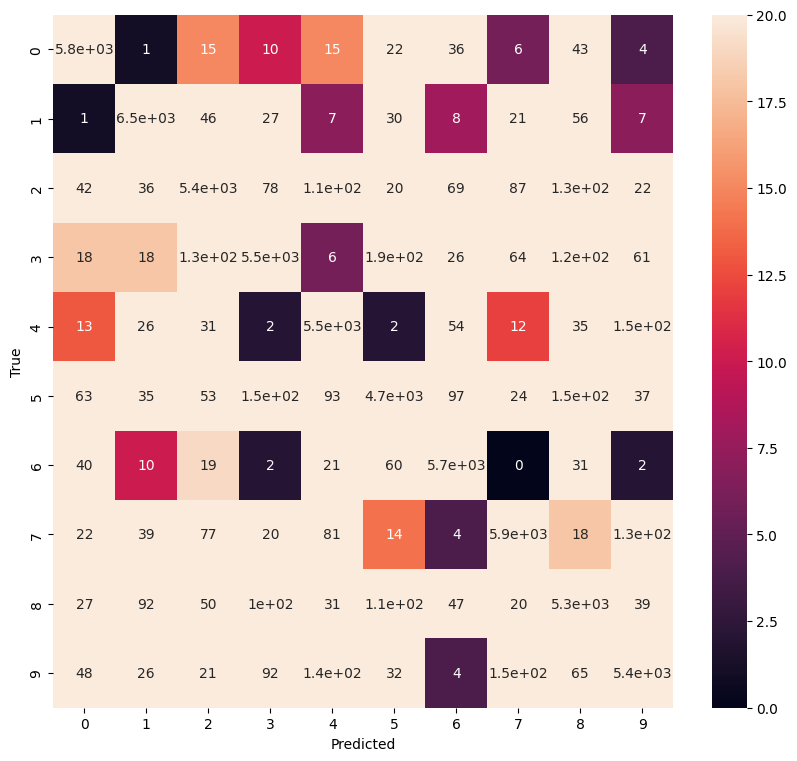

In [15]:
import seaborn as sns

plt.subplots(figsize=(10,9))
ax = sns.heatmap(conf_matrix, annot=True, vmax=20)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')